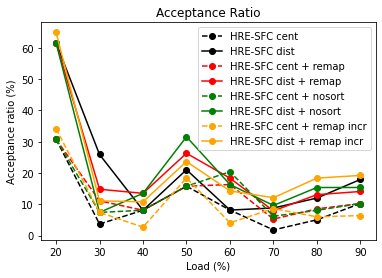

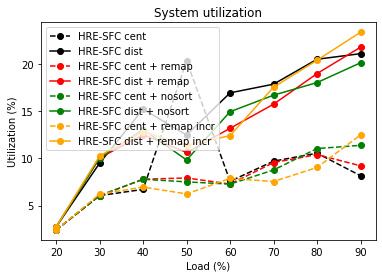

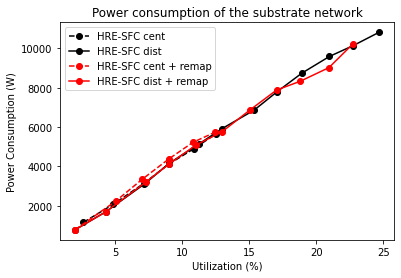

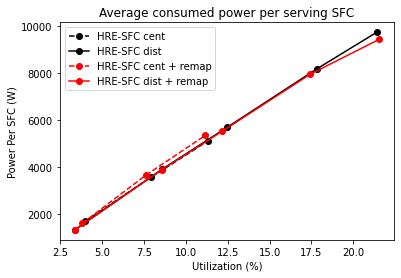

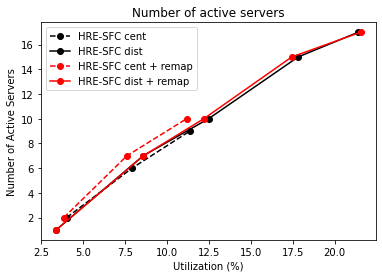

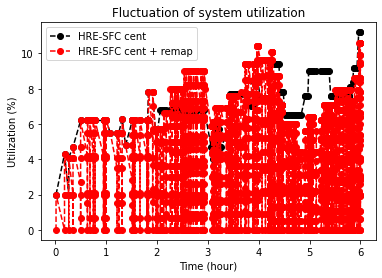

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import csv

COLUMN_TIME = 1
COLUMN_ACTION = 2
COLUMN_NVNFS = 5
COLUMN_DEMAND = 6
COLUMN_UTIL = 9
COLUMN_MIGRATION = 10
COLUMN_POWER = 12
COLUMN_PPERSFC = 13
COLUMN_ACTIVE_SERVER = 14

markers = ["o","o","o","o","o","o","o","o","o","o"]
colors = ["black","black","red","red","green","green","orange","orange","cyan","cyan"]

def open_data():
    folder_name = 'results/100_2_120_420_1040_1090_700/'
    data = []
    label = []
    linestyle = []

    def foo(dir, note): # i dont know how to name this function @@
        f = open(folder_name + dir[0])
        data.append(csv.reader(f))
        label.append(note[0])
        linestyle.append('--')
        f = open(folder_name + dir[1])
        data.append(csv.reader(f))
        label.append(note[1])
        linestyle.append(None)

    foo(["limited/cent_1_event.csv", "limited/dist_1_event.csv"],
        ["HRE-SFC cent", "HRE-SFC dist"])

    foo(["limited/cent_2d_event.csv", "limited/dist_2d_event.csv"],
        ["HRE-SFC cent + remap", "HRE-SFC dist + remap"])

    foo(["limited/cent_2n_event.csv", "limited/dist_2n_event.csv"],
        ["HRE-SFC cent + nosort", "HRE-SFC dist + nosort"])

    foo(["limited/cent_2i_event.csv", "limited/dist_2i_event.csv"],
        ["HRE-SFC cent + remap incr", "HRE-SFC dist + remap incr"])

    # foo(["inf/cent_1_event.csv", "inf/dist_1_event.csv"],
    #     ["HRE-SFC cent inf", "HRE-SFC dist inf"])

    return data, label, linestyle


def round_load(load, ydata):
    new_data = [0]*10
    count = [0]*10
    for i in range(len(load)):
        if load[i] < 10: itr = 0
        else:
            itr = round(load[i]/10)-1
        count[itr] += 1
        new_data[itr] += ydata[i]
    result_load = []
    result_y = []
    for i in range(len(count)):
        if count[i] > 0:
            result_load.append((i+1)*10)
            result_y.append(new_data[i]/count[i])
    
    return result_load, result_y


def average(value, time, period, lastValue):
    sum = lastValue * (time[0] % period)
    for i in range(len(time)):
        if(i == len(time) - 1):
            time[i] = ((time[0] // period + 1) * period) - (time[i] % 60)
        else:
            time[i] = time[i+1] - time[i]
        sum += value[i] * time[i]
    avg = sum / period
    return avg


def Acceptance(data_id=[], round=False):
    """
    Acceptance ratio: Load (%) - Acceptance Ratio (%)
    """
    data, label, ls = open_data()
    def draw(data, marker, color, label, linestyle):
        load = [0]
        drop = [0]
        deploy = [0]
        c = 0
        for row in data:
            if row[COLUMN_TIME] != 'time':
                hour = int(row[COLUMN_TIME]) // 60
                if hour > c:
                    load.append(0)
                    drop.append(0)
                    deploy.append(0)
                    c += 1
            if row[COLUMN_ACTION] == 'create':
                load[hour] += int(row[COLUMN_DEMAND])
            if row[COLUMN_ACTION] == 'deploy':
                deploy[hour] += 1
            if row[COLUMN_ACTION] == 'drop':
                drop[hour] += 1
        load = np.array(load) / np.array([100 * 250 / 100] * len(load))
        acceptance = np.array(deploy) * 100 / (np.array(deploy) + np.array(drop))
        if(round == False):
            plt.plot(load[np.argsort(load)], acceptance[np.argsort(load)], linestyle=linestyle, marker=marker, color=color, label=label)
        else:
            load, acceptance = round_load(load,acceptance)
            plt.plot(load, acceptance, linestyle=linestyle, marker=marker, color=color, label=label)

    fig, ax = plt.subplots()

    if data_id == []:
        for itr in range(len(data)):
            draw(data[itr], marker=markers[itr], color=colors[itr], label=label[itr], linestyle=ls[itr])
    else:
        for itr in data_id:
            draw(data[itr], marker=markers[itr], color=colors[itr], label=label[itr], linestyle=ls[itr])

    plt.xlabel("Load (%)")
    plt.ylabel("Acceptance ratio (%)")
    ax.set_title("Acceptance Ratio")
    ax.legend()
    plt.show()


def Utilization(data_id=[], round=False):
    """
    System utilization: Load (%) - Utilization (%)
    """
    data, label, ls = open_data()
    def draw(data, marker, color, label, linestyle):
        load = [0]

        util = [0]
        _util = []
        time_util = []
        last_util = 0

        c = 0

        for row in data:
            if(row[COLUMN_TIME] != 'time'):
                hour = int(row[COLUMN_TIME]) // 60
                if hour > c:
                    load.append(0)

                    util.append(average(_util, time_util, 60, last_util))
                    last_util = _util[-1]
                    _util = []
                    time_util = []

                    c += 1
            if row[COLUMN_ACTION] == 'create':
                load[hour] += int(row[COLUMN_DEMAND])
            if(row[COLUMN_ACTION] in ['deploy', 'remove']):
                _util.append(float(row[COLUMN_UTIL]))
                time_util.append(int(row[COLUMN_TIME]))

        load = np.array(load) / np.array([100 * 250 / 100] * len(load))
        util = np.array(util)
        if round == False:
            plt.plot(load[np.argsort(load)], util[np.argsort(load)], marker=marker, color=color, label=label, linestyle=linestyle)
        else:
            load, util = round_load(load,util)
            plt.plot(load, util, marker=marker, color=color, label=label, linestyle=linestyle)
    
    fig, ax = plt.subplots()

    if(data_id == []):
        for itr in range(len(data)):
            draw(data[itr], marker=markers[itr], color=colors[itr], label=label[itr], linestyle=ls[itr])
    else:
        for itr in data_id:
            draw(data[itr], marker=markers[itr], color=colors[itr], label=label[itr], linestyle=ls[itr])

    plt.xlabel("Load (%)")
    plt.ylabel("Utilization (%)")
    ax.set_title("System utilization")
    ax.legend()
    plt.show()


def Power(data_id=[]):
    """
    Power consumption: Utilization (%) - Power Consumption (W)
    """
    data, label, ls = open_data()

    def draw(data, reso, marker, color, label, linestyle):
        n_value = 100 // reso
        power = [0] * n_value
        util = [0] * n_value
        count = [0] * n_value
        for row in data:
            if(row[COLUMN_ACTION] in ["deploy", "remove"]):
                i = int(float(row[COLUMN_UTIL]) / reso)
                power[i] += float(row[COLUMN_POWER])
                util[i] += float(row[COLUMN_UTIL])
                count[i] += 1

        _length = len(count)
        i = 0
        while i < _length:
            try:
                if count[i] == 0:
                    power.pop(i)
                    util.pop(i)
                    count.pop(i)
                    _length -= 1
                else:
                    i += 1
            except:
                break
            
        power = np.array(power) / np.array(count)
        util = np.array(util) / np.array(count)
        plt.plot(util, power, marker=marker, color=color, label=label, linestyle=linestyle)

    fig, ax = plt.subplots()

    if(data_id == []):
        for itr in range(len(data)):
            draw(data[itr], 2, marker=markers[itr], color=colors[itr], label=label[itr], linestyle=ls[itr])
    else:
        for itr in data_id:
            draw(data[itr], 2, marker=markers[itr], color=colors[itr], label=label[itr], linestyle=ls[itr])

    plt.xlabel("Utilization (%)")
    plt.ylabel("Power Consumption (W)")
    ax.set_title("Power consumption of the substrate network")
    ax.legend()
    plt.show()


def PowerPerSFC(data_id = None):
    """
    Average consumed power per serving SFC: Utilization (%) - Power Per SFC (W)
    """
    data, label, ls = open_data()
    def draw(data, reso, marker, color, label, linestyle):
        n_value = 100 // reso
        pps = [0] * n_value
        util = [0] * n_value
        count = [0] * n_value
        for row in data:
            if(row[COLUMN_ACTION] in ["deploy", "remove"]):
                i = int(float(row[COLUMN_UTIL]) / reso)
                pps[i] += float(row[COLUMN_POWER])
                util[i] += float(row[COLUMN_UTIL])
                count[i] += 1
        _length = len(count)
        i = 0
        while i < _length:
            try:
                if count[i] == 0:
                    pps.pop(i)
                    util.pop(i)
                    count.pop(i)
                    _length -= 1
                else:
                    i += 1
            except:
                break
        pps = np.array(pps) / np.array(count)
        util = np.array(util) / np.array(count)
        plt.plot(util, pps, marker=marker, color=color, label=label, linestyle=linestyle)
        
        
    fig, ax = plt.subplots()

    if data_id == None:
        for itr in range(len(data)):
            draw(data[itr], 5, marker=markers[itr], color=colors[itr], label=label[itr], linestyle=ls[itr])
    else:
        for itr in data_id:
            draw(data[itr], 5, marker=markers[itr], color=colors[itr], label=label[itr], linestyle=ls[itr])

    
    plt.xlabel("Utilization (%)")
    plt.ylabel("Power Per SFC (W)")
    ax.set_title("Average consumed power per serving SFC")
    ax.legend()
    plt.show()


def ActiveServer(data_id = None):
    """
    Number of active servers: Utilization (%) - Number of Active Servers
    """
    data, name, ls = open_data()
    def draw(data, reso, marker, color, label, linestyle):
        n_value = 100 // reso
        aserver = [0] * n_value
        util = [0] * n_value
        count = [0] * n_value
        for row in data:
            if(row[COLUMN_ACTION] in ["deploy", "remove"]):
                i = int(float(row[COLUMN_UTIL]) / reso)
                aserver[i] += int(row[COLUMN_ACTIVE_SERVER])
                util[i] += float(row[COLUMN_UTIL])
                count[i] += 1

        _length = len(count)
        i = 0
        while i < _length:
            try:
                if count[i] == 0:
                    aserver.pop(i)
                    util.pop(i)
                    count.pop(i)
                    _length -= 1
                else:
                    i += 1
            except:
                break

        aserver = np.array(aserver) // np.array(count)
        util = np.array(util) / np.array(count)
        plt.plot(util, aserver, marker=marker, color=color, label=label, linestyle=linestyle)
    
    fig, ax = plt.subplots()

    if data_id == None:
        for itr in range(len(data)):
            draw(data[itr], 5, marker=markers[itr], color=colors[itr], label=name[itr], linestyle=ls[itr])
    else:
        for itr in data_id:
            draw(data[itr], 5, marker=markers[itr], color=colors[itr], label=name[itr], linestyle=ls[itr])

    plt.xlabel("Utilization (%)")
    plt.ylabel("Number of Active Servers")
    ax.set_title("Number of active servers")
    ax.legend()
    plt.show()


def Figure6(start_time,end_time,time_format='hour',data_id = None):
    """Fluctuation of system utilization:

    Time (hour) - Utilization (%)

    start_time, end_time: Thời gian bắt đầu và kết thúc

    time_format: Định dạng thời gian của start_time và end_time, có giá trị là 'hour' và 'minute'. Mặc định là 'hour'
    """
    data, name, ls = open_data()
    if time_format == 'hour':
        start_time = start_time*60
        end_time = end_time*60

    def plottable(data, marker, color, label, linestyle):
        time = []
        util = []
        for row in data:
            if row[1] == 'time' or int(row[COLUMN_TIME]) < start_time or int(row[COLUMN_TIME]) > end_time or row[COLUMN_ACTION] == 'create' or row[COLUMN_UTIL] == '-': continue
            else:
                time.append(int(row[COLUMN_TIME]))
                util.append(float(row[COLUMN_UTIL]))

        plt.plot(np.array(time)/60, np.array(util), marker=marker, color=color, label=label, linestyle=linestyle)
    
    fig, ax = plt.subplots()

    if data_id == None:
        for itr in range(len(data)):
            plottable(data[itr], marker=markers[itr], color=colors[itr], label=name[itr], linestyle=ls[itr])
    else:
        for itr in data_id:
            plottable(data[itr], marker=markers[itr], color=colors[itr], label=name[itr], linestyle=ls[itr])

    plt.xlabel("Time (hour)")
    plt.ylabel("Utilization (%)")
    ax.set_title("Fluctuation of system utilization")
    ax.legend()
    plt.show()


if __name__ == "__main__":
    paper_input = [0, 1, 2, 3]
    all_input = [0, 1, 2, 3, 4, 5, 6, 7]
    Acceptance(data_id=all_input, round=True)
    Utilization(data_id=all_input, round=True)
    Power(data_id=paper_input)
    PowerPerSFC(data_id=paper_input)
    ActiveServer(paper_input)
    Figure6(start_time=0,end_time=6,data_id=[0,2])